In [148]:
#data management imports
import numpy as np
import pandas as pd

#plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

#modeling imports
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

#misc python packages
from IPython.display import clear_output
import time

#for map plotting
import shapely
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

### Top 10 species in Northern/Southern region

In [124]:
spe = ['loblolly pine','sweetgum','red maple','slash pine','yellow-poplar',
      'balsam fir','sugar maple','quaking aspen','northern white-cedar','paper birch']

### Load tree data, clean data and prepare features

In [125]:
#load trees data
trees = pd.read_csv('county_tree_temp_dwp_prcp_KT_NS10.csv')
trees = trees.sort_values(['state_code','county_code','species','year'])
trees = trees.reset_index(drop = True)

#clean data
trees = trees.drop(trees.loc[(trees.volume == 0) | (trees.height == 0)].index)

le = LabelEncoder()
trees['speciesID'] = le.fit_transform(trees.species)
trees['volume'] = trees['volume'] / trees['number_trees']
trees['Biomass'] = trees['Biomass'] / trees['number_trees']
trees['height'] = trees['height'] / trees['number_trees']
trees['diameter'] = trees['diameter'] / trees['number_trees']
trees['Density'] = trees['Biomass']/trees['volume']
trees['logMass'] = np.log(trees['Biomass'])
trees['logvolume'] = np.log(trees['volume'])
trees['logdensity'] = np.log(trees['Density'])
trees = trees.drop(trees.loc[trees.Density > 100].index)

species = trees.species.unique()

### Make a few interesting plots

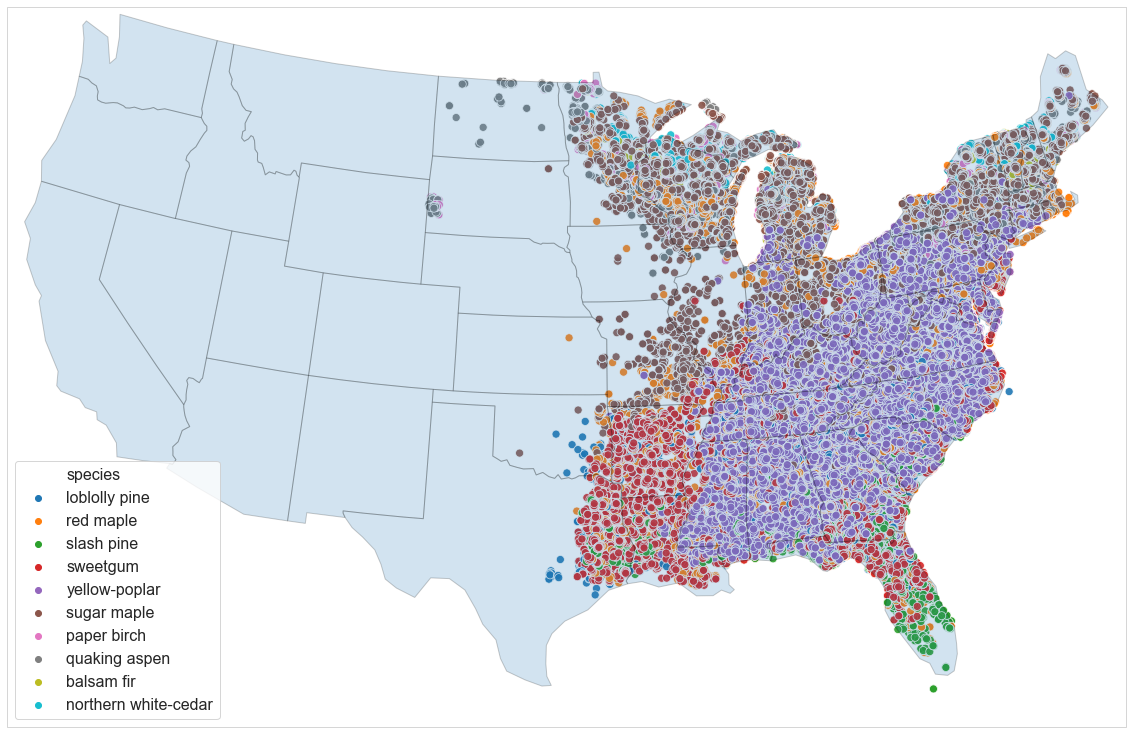

In [162]:
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m',category='cultural', name=shapename)

xf = 'longitude'
yf = 'latitude'
fig = plt.figure(figsize = (16,10))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
ax.set_extent([-119, -74, 22, 50], ccrs.Geodetic())
ax.add_geometries(shpreader.Reader(states_shp).geometries(), ccrs.PlateCarree(),alpha = 0.2, edgecolor='k')
sns.scatterplot(data=trees.loc[trees.species.isin(spe)],x=xf,y=yf,hue="species", 
                alpha=0.9,ax = ax,transform=ccrs.PlateCarree(),s = 65)
ax.legend(loc = 3,fontsize = 16)
plt.show()

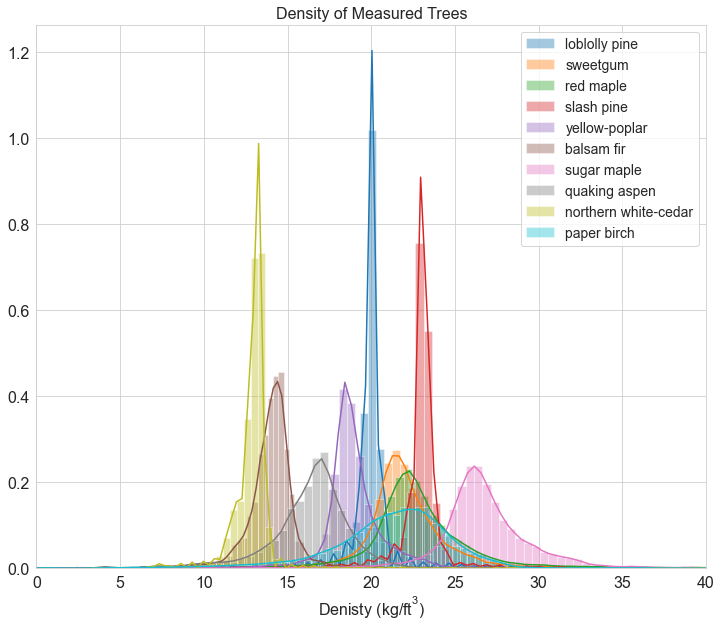

In [157]:
plt.figure(figsize=(12,10))
for i,s in enumerate(spe):
    sns.distplot(trees.loc[(trees.species == s) & (trees.Density < 50)]['Density'],
                 bins = 100,label = s)
plt.legend(fontsize = 12)
plt.xlabel('Denisty ($\mathregular{kg/ft^3}$)',fontsize = 16)
plt.title('Density of Measured Trees',fontsize = 16)
plt.xlim((0,40))
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 14)
plt.show()

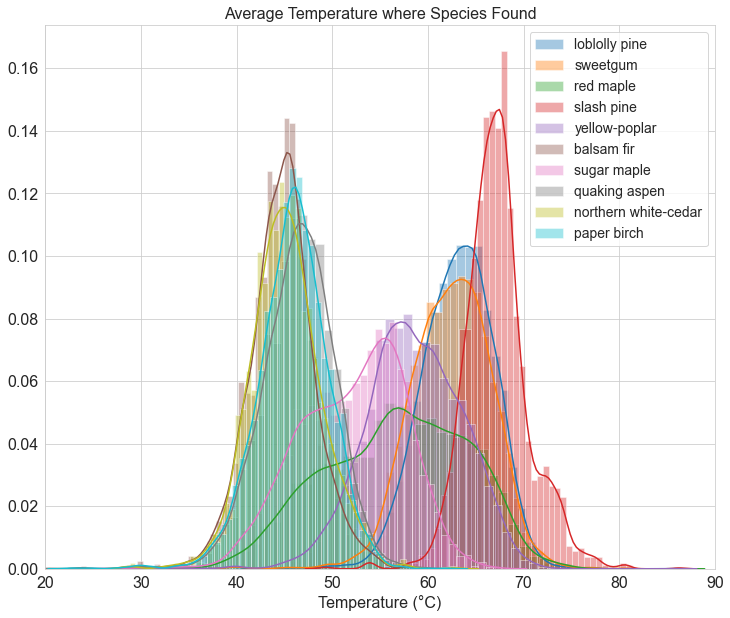

In [156]:
plt.figure(figsize=(12,10))
for i,s in enumerate(spe):
    sns.distplot(trees.loc[(trees.species == s) & (trees.Density < 50)]['mean_temp'],
                 bins = 60,label = s)
plt.legend(fontsize = 12)
plt.xlabel(u'Temperature (\N{DEGREE SIGN}C)',fontsize = 16)
plt.title('Average Temperature where Species Found',fontsize = 16)
plt.xlim((20,90))
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 14)
plt.show()

## Classification using Neural Network MLP, Final Model

In [126]:
#make models
scaler = StandardScaler()
mlp = MLPClassifier(hidden_layer_sizes=(100,),max_iter=1000)
pipe = Pipeline([('scaler',scaler),('NeurlNet',mlp)])

In [127]:
#define features to be used
features = ['latitude','longitude','Density','mean_temp','height','logdensity',
            'Biomass','diameter','mean_prcp','mean_dwp','volume','logMass','logvolume']

In [128]:
#split data
trees10 = trees.loc[trees.species.isin(spe)].copy() #top 10 trees
train,test = train_test_split(trees10,test_size=.1,shuffle=True,stratify = trees10.speciesID,random_state = 42)

In [129]:
#perform cv fit on training data, get predicted values
t0 = time.perf_counter()
y = train.speciesID
X = train[features].copy()
pred = cross_val_predict(pipe,X,y, cv=5, n_jobs = -1)
t1 = time.perf_counter()
print(f'Runtime: {t1-t0} seconds')

Runtime: 259.4059563999981 seconds


## Get accuracy, precision, recall for the model

For Andrew working on the ensemble, everything past this point is just looking at the model, the code above did the actual model fitting and is probably more what you need than the stuff below

In [130]:
print(precision_score(y,pred, average = 'macro'))
print(recall_score(y,pred, average = 'macro'))
print(accuracy_score(y,pred))

0.8485970477242197
0.847640640635321
0.8426510558227054


In [131]:
precision = precision_score(y,pred, average = None)
recall = recall_score(y,pred, average = None)
matrix = confusion_matrix(y, pred)
accuracy = matrix.diagonal()/matrix.sum(axis=0)

speID = le.transform(spe)
orderedspecies = le.inverse_transform(np.sort(speID))

final = pd.DataFrame({'accuracy':accuracy,
                      'recall':recall,
                      'precision':precision},
                     index = orderedspecies)

final.loc['Total'] = [accuracy_score(y,pred),
                      recall_score(y,pred, average = 'macro'),
                      precision_score(y,pred, average = 'macro')]
final

,accuracy,recall,precision
balsam fir,0.885496,0.916754,0.885496
loblolly pine,0.855193,0.899809,0.855193
northern white-cedar,0.906388,0.922730,0.906388
paper birch,0.749253,0.652669,0.749253
quaking aspen,0.868646,0.920232,0.868646
red maple,0.801231,0.795689,0.801231
slash pine,0.832367,0.795484,0.832367
sugar maple,0.965817,0.941262,0.965817
sweetgum,0.763540,0.728524,0.763540
yellow-poplar,0.858038,0.903253,0.858038


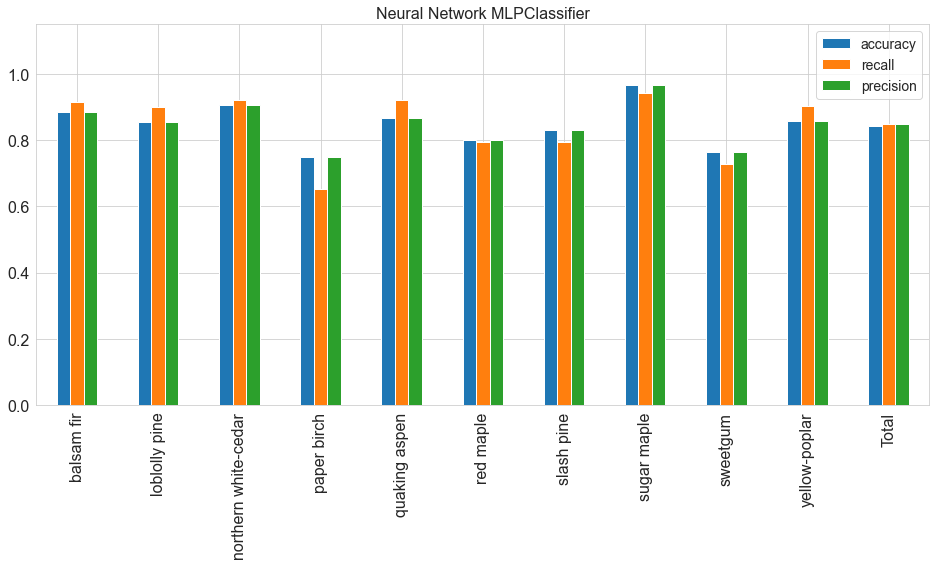

In [132]:
final.plot.bar(fontsize = 16,figsize = (16,7),legend = False)
plt.ylim((0,1.15))
plt.xlabel('',fontsize = 16)
plt.title('Neural Network MLPClassifier',fontsize = 16)
plt.legend(loc = 1,fontsize = 14)
plt.show()

## Everything below this point was used to determine the ideal parameters, not used anymore

#### Look at ideal number of features

In [45]:
runs = [4,6,8,9,13] #setup loop ranges for features (impractictical to do 1-13)
t0 = time.perf_counter()
y = train.speciesID
score = np.zeros((5,3))
for i,r in enumerate(runs):
    clear_output()
    print(f'Now working on {i}')
    f = features[:r]
    X = train[f].copy()
    score[i,:] = cross_val_score(mlp, X, y, cv=3, n_jobs = -1)
clear_output()
t1 = time.perf_counter()
print(f'Runtime: {t1-t0} seconds')
score.mean(axis = 1)

Runtime: 202.9739658999997 seconds


array([0.60559478, 0.63168721, 0.62811063, 0.60415124, 0.71993927])

#### look at ideal number of layers

In [53]:
t0 = time.perf_counter()
layer = np.arange(1,10,1)
score = np.zeros((layer.size,3))
y = train.speciesID
for i,l in enumerate(layer):
    mlp = MLPClassifier(hidden_layer_sizes=(l,),max_iter=1000)
    clear_output()
    print(f'Now working on {i}')
    f = features[:13]
    X = train[f].copy()
    score[i,:] = cross_val_score(mlp, X, y, cv=3, n_jobs = -1)
clear_output()
t1 = time.perf_counter()
print(f'Runtime: {t1-t0} seconds')
score.mean(axis = 1)

Runtime: 668.4076430000023 seconds


array([0.25992055, 0.49278695, 0.51041884, 0.63222524, 0.68842428,
       0.6981253 , 0.72301903, 0.72824587, 0.73777964])

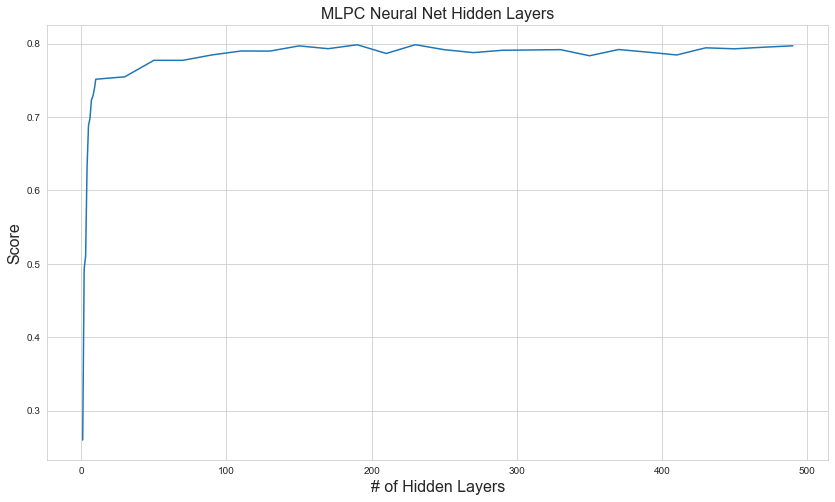

In [60]:
LayerScore = [0.25992055, 0.49278695, 0.51041884, 0.63222524, 0.68842428,
              0.6981253 , 0.72301903, 0.72824587, 0.73777964,0.75145306, 
              0.75474249, 0.77719702, 0.77719702, 0.78455642,0.7899087 , 
              0.7897972 , 0.79687783, 0.79304481, 0.79841104,0.78653565, 
              0.79850861, 0.79167886, 0.78770646, 0.79089832,0.79130253, 
              0.79176249, 0.78342742, 0.79191581, 0.78833368,0.78450066, 
              0.7942435 , 0.79289149, 0.79509373, 0.7969754 ]
layer  = [1, 2, 3, 4, 5, 6, 7, 8, 9,
          10,  30,  50,  70,  90, 110, 130, 150, 170, 
          190, 210, 230, 250,270, 290, 310, 330, 350,
          370, 390, 410, 430, 450, 470, 490]
plt.figure(figsize = (14,8))
plt.plot(layer,LayerScore)
plt.ylabel('Score',fontsize = 16)
plt.xlabel('# of Hidden Layers',fontsize = 16)
plt.title('MLPC Neural Net Hidden Layers',fontsize = 16)
plt.show()

#### Looking at if standard scaler is worth using or not (hint, it is!)

In [61]:
mlp = MLPClassifier(hidden_layer_sizes=(100,),max_iter=1000)

t0 = time.perf_counter()
y = train.speciesID
f = features[:13]
X = train[f].copy()
score = cross_val_score(mlp, X, y, cv=3, n_jobs = -1)

t1 = time.perf_counter()
print(f'Runtime: {t1-t0} seconds')
print(score.mean())

t0 = time.perf_counter()
y = train.speciesID
f = features[:13]
X = train[f].copy()
X = scaler.fit_transform(X)
score = cross_val_score(mlp, X, y, cv=3, n_jobs = -1)

t1 = time.perf_counter()
print(f'Runtime: {t1-t0} seconds')
print(score.mean())

Runtime: 408.84694540000055 seconds
0.7833159105164124
Runtime: 174.20048910000332 seconds
0.8393058749738658


In [96]:
mlp = MLPClassifier(hidden_layer_sizes=(100,),max_iter=1000)
scaler = StandardScaler()

t0 = time.perf_counter()
y = train.speciesID
X = train[features].copy()
X = scaler.fit_transform(X)

mlp.fit(X,y)
t1 = time.perf_counter()
print(f'Runtime: {t1-t0} seconds')

Runtime: 228.9641072000013 seconds


In [97]:
print(mlp.score(X,y))
print(precision_score(y,mlp.predict(X), average = 'macro'))
print(recall_score(y,mlp.predict(X), average = 'macro'))
print(accuracy_score(y,mlp.predict(X)))

0.8511952052407833
0.8636078675316826
0.8502561766699379
0.8511952052407833


### Everything below here is not functioning, just bits and pieces of code from previous tests

In [182]:
spe5 = mlp.predict(x_test)
NN = pd.DataFrame(columns = ['speciesID','correct'])
NN['speciesID'] = y_test
NN['correct'] = mlp.predict(x_test) == y_test
NN = NN.reset_index(drop = True)

In [165]:
accpd = pd.DataFrame(columns = ['species','acc'])
for i,s in enumerate(spe):
    sid = le.transform([s])
    samp = NN.loc[NN.speciesID == sid[0]]
    acc = sum(samp['correct']) / len(samp)
    accpd.loc[i] = [s,acc]
accpd

,species,acc
0,loblolly pine,0.896970
1,sweetgum,0.739092
2,red maple,0.839286
3,slash pine,0.793103
4,yellow-poplar,0.896321


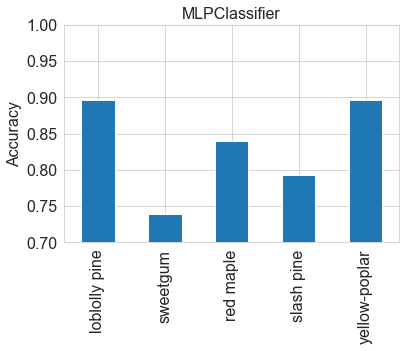

In [181]:
accpd.plot.bar(x='species', y='acc',fontsize = 16,legend = False)
plt.ylim((0.7,1))
plt.ylabel('Accuracy',fontsize = 16)
plt.xlabel('',fontsize = 16)
plt.title('MLPClassifier',fontsize = 16)
plt.show()